<div>
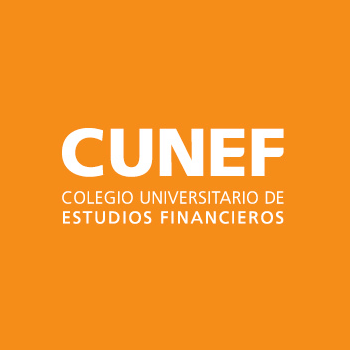
</div>

# **Número de pernoctaciones en España**

## *Librerías*

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del CSV y preparación de los datos*
Se procede a leer el archivo CSV del número de viajeros y pernoctaciones que hubo y hay en España.

- Fuente: https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177015&menu=ultiDatos&idp=1254735576863

In [79]:
df_pernoc = pd.read_csv("Pernoctaciones.csv",sep="\t", on_bad_lines='skip')
df_pernoc 

,Totales Territoriales,Comunidades y Ciudades Autónomas,Provincias,Viajeros y pernoctaciones,Residencia: Nivel 1,Residencia: Nivel 2,Periodo,Total
0,Total Nacional,NaN,NaN,Viajero,Total,NaN,2022M02,5.142.667
1,Total Nacional,NaN,NaN,Viajero,Total,NaN,2022M01,3.751.404
2,Total Nacional,NaN,NaN,Viajero,Total,NaN,2021M12,4.869.737
3,Total Nacional,NaN,NaN,Viajero,Total,NaN,2021M11,5.370.287
4,Total Nacional,NaN,NaN,Viajero,Total,NaN,2021M10,8.102.328
...,...,...,...,...,...,...,...,...
116755,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en el Extranjero,1999M05,1.305
116756,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en el Extranjero,1999M04,1.668
116757,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en el Extranjero,1999M03,1.673
116758,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en el Extranjero,1999M02,1.487


Observamos que el DataFrame que nos lee Jupyter Notebook tiene varios valores en las filas en cada variable, vamos a mirar qué contiene en las variables "Comunidades y Ciudades Autónomas" y "Viajeros y pernoctaciones" por si nos interesa para algo en nuestro análisis:

In [80]:
df_pernoc['Comunidades y Ciudades Autónomas'].unique()

array([nan, '01 Andalucía', '02 Aragón', '03 Asturias, Principado de',
       '04 Balears, Illes', '05 Canarias', '06 Cantabria',
       '07 Castilla y León', '08 Castilla - La Mancha', '09 Cataluña',
       '10 Comunitat Valenciana', '11 Extremadura', '12 Galicia',
       '13 Madrid, Comunidad de', '14 Murcia, Región de',
       '15 Navarra, Comunidad Foral de', '16 País Vasco', '17 Rioja, La',
       '18 Ceuta', '19 Melilla'], dtype=object)

In [81]:
df_pernoc['Viajeros y pernoctaciones'].unique()

array(['Viajero', 'Pernoctaciones'], dtype=object)

Del dataframe, lo único que nos interesa son los datos de pernoctaciones totales (desde la fila 836 del CSV hasta la 1113) y el periodo para las series temporales:

In [82]:
df_pernoc = df_pernoc.iloc[834:1112, -2:]
df_pernoc

,Periodo,Total
834,2022M02,13.619.131
835,2022M01,10.535.401
836,2021M12,13.189.569
837,2021M11,14.859.231
838,2021M10,23.878.482
...,...,...
1107,1999M05,21.966.528
1108,1999M04,17.472.798
1109,1999M03,14.212.113
1110,1999M02,11.451.100


Convertimos en formato fecha y lo indexamos.

In [83]:
df_pernoc['Periodo'] = df_pernoc['Periodo'].str.replace('M', '')
df_pernoc['Periodo'] = pd.to_datetime(df_pernoc['Periodo'], format='%Y%m')

In [84]:
df_pernoc = df_pernoc.set_index("Periodo")
df_pernoc

,Total
Periodo,
2022-02-01,13.619.131
2022-01-01,10.535.401
2021-12-01,13.189.569
2021-11-01,14.859.231
2021-10-01,23.878.482
...,...
1999-05-01,21.966.528
1999-04-01,17.472.798
1999-03-01,14.212.113


In [85]:
df_pernoc['Total']=df_pernoc['Total'].str.replace('.', '').astype(float)

## *Graficación de la serie temporal*

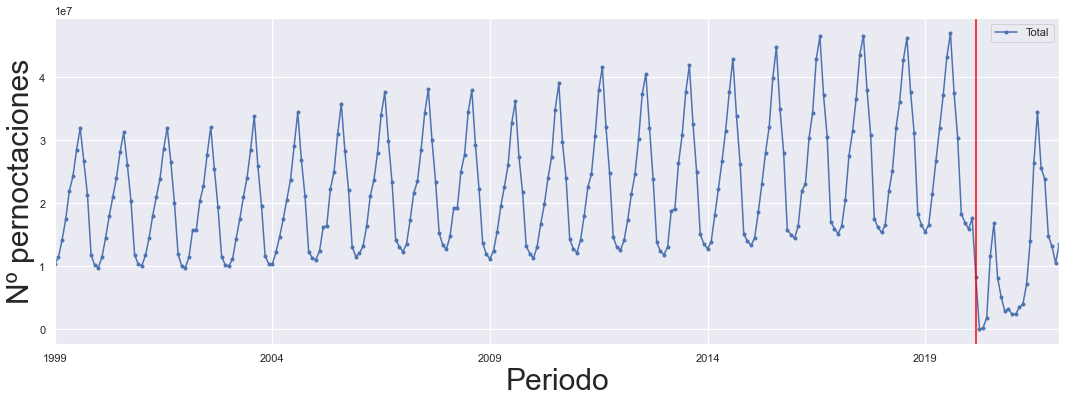

In [86]:
sns.set(rc={'figure.figsize':(18, 6)})
fig = df_pernoc.plot(marker='.') 
fig.set_ylabel('Nº pernoctaciones', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

La gráfica distorsiona algo los datos más recientes, aunque por cómo es podemos adivinar hacia dónde va su tendencia y estacionalidad, pero vamos a aplicar un zoom desde finales del 2013 en adelante:

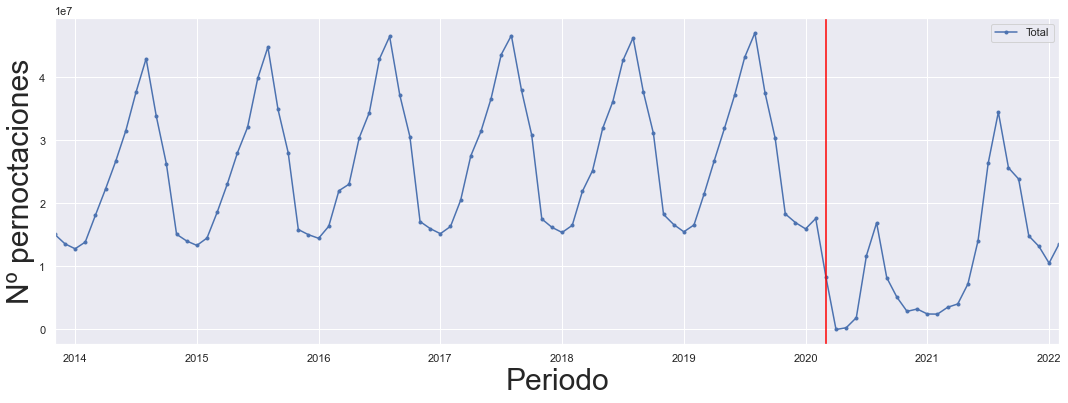

In [87]:
df_pernoc = df_pernoc.iloc[:100]

sns.set(rc={'figure.figsize':(18, 6)})
fig = df_pernoc.plot(marker='.') 
fig.set_ylabel('Nº pernoctaciones', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

Pues como tendencia, podemos ver que es creciente con una fuerte estacionalidad en el verano y en el invierno, pero que cuando llega el COVID la tendencia se vuelve decreciente, aunque se ve indicios de recuperación y cambio a creciente a mediados del 2021.


A continuación, analizaremos la estacionalidad mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

In [31]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [33]:
media = split_and_summarize(df_pernoc, 'Total', 4, np.mean)

varianza = split_and_summarize(df_pernoc, 'Total', 4, np.var)

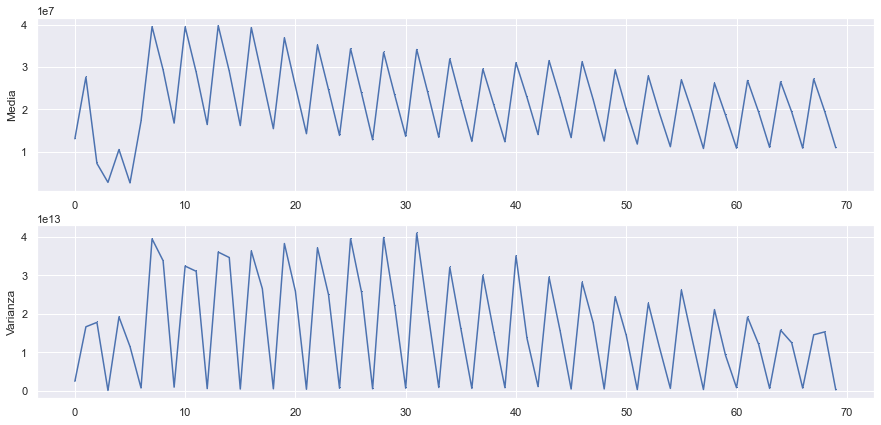

In [34]:
cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

<font color='red'>CORREGIR ESTO</font>

ValueError: Expected frequency -1MS. Got M

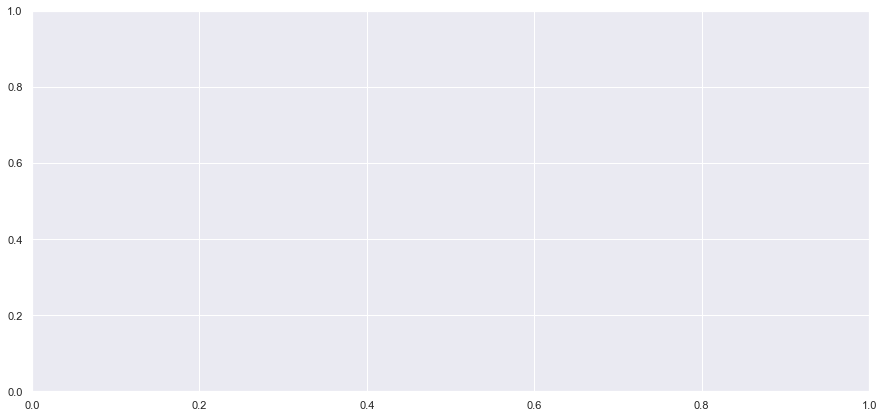

In [35]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_pernoc['Total'], ax = ax)
ax.set_title('Comportamiento mensual', fontsize = 30);

Pasamos a realizar un boxplot mensual:

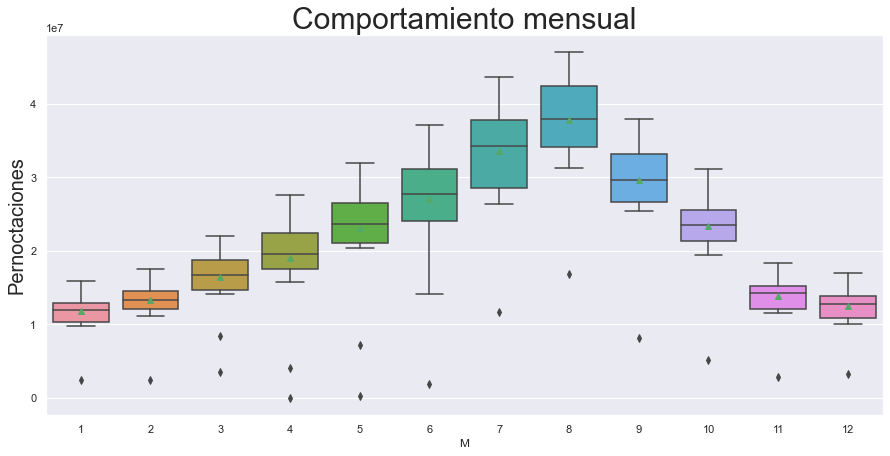

In [37]:
df_pernoc['M'] = df_pernoc.index.month
sns.boxplot(data = df_pernoc, x = 'M', y='Total', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Pernoctaciones', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);

Por último, el desglose de su estacionalidad, tendencia y residuos:

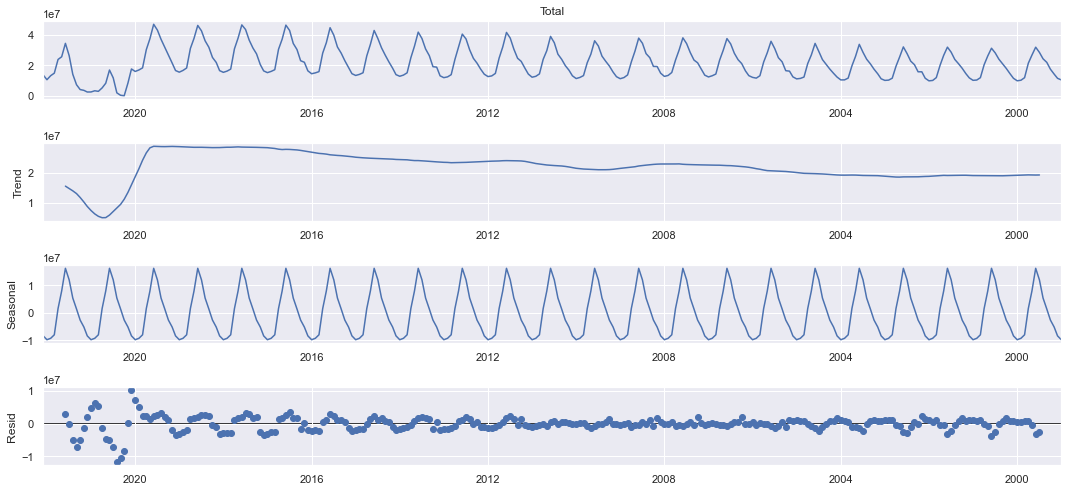

In [38]:
desglose = seasonal_decompose(df_pernoc['Total'], 
                                   model='additive', 
                                   period=12);
desglose.plot();

Analizando las gráficas, observamos:
- Lo comentado anteriormente, su ligera tendencia creciente con la excepción del inicio de la época COVID y la marcada estacionalidad en las estaciones de verano e invierno.
- La media y la varianza es constante, por lo que además estamos en una serie temporal con estacionariedad.

## *Modelo de suavizado exponencial (ETS)*
A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en un año.